In [55]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import WeibullAFTFitter, LogLogisticAFTFitter, ExponentialFitter
import seaborn as sns
import os


# Create output directory for figures if it doesn't exist
os.makedirs('figures', exist_ok=True)

# Set visualization style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)

#  Load and Explore Data

In [56]:
# Load the dataset
df = pd.read_csv('Churn_Data_cleaned.csv')

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
display(df.head())

# Check for missing values in key columns
print("\nMissing values in key columns:")
display(df[['churn', 'months']].isnull().sum())

# Basic statistics of key variables
print("\nBasic statistics of key variables:")
display(df[['churn', 'months', 'totmrc_Mean', 'mou_Mean', 'rev_Mean', 'ovrmou_Mean']].describe())

Dataset shape: (93893, 108)


,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,change_rev,drop_vce_Mean,drop_dat_Mean,blck_vce_Mean,blck_dat_Mean,unan_vce_Mean,unan_dat_Mean,recv_vce_Mean,recv_sms_Mean,comp_vce_Mean,comp_dat_Mean,custcare_Mean,ccrndmou_Mean,cc_mou_Mean,inonemin_Mean,threeway_Mean,mou_cvce_Mean,mou_cdat_Mean,mou_rvce_Mean,owylis_vce_Mean,mouowylisv_Mean,iwylis_vce_Mean,mouiwylisv_Mean,peak_vce_Mean,peak_dat_Mean,mou_peav_Mean,mou_pead_Mean,opk_vce_Mean,opk_dat_Mean,mou_opkv_Mean,mou_opkd_Mean,drop_blk_Mean,complete_Mean,callfwdv_Mean,callwait_Mean,churn,months,uniqsubs,actvsubs,new_cell,crclscod,asl_flag,rmcalls,rmmou,totcalls,totmou,totrev,adjrev,adjmou,adjqty,avgrev,avgmou,avgqty,avg3mou,avg3qty,avg3rev,avg6mou,avg6qty,avg6rev,csa,area,dualband,refurb_new,hnd_price,phones,models,hnd_webcap,truck,mtrcycle,rv,ownrent,dwlltype,marital,age1,age2,adults,income,numbcars,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,car_buy,eqpdays,Customer_ID,mail,phoneswap,retentioncall,acptcall,referrals,pcowner_binary,women,mailordr_binary,mailresp_binary
0,23.9975,219.25,22.50,0.2475,0.0,0.0,0.0,0.0,0.0,-157.25,-18.9975,0.666667,False,0.666667,False,6.333333,False,42.333333,False,45.000000,0.0,0.000000,0.0,0.000000,18.000000,0.000000,90.643333,0.0,97.176667,0.000000,0.000000,0.000000,0.000000,58.000000,False,132.600000,False,24.000000,False,55.220000,False,1.333333,45.000000,False,0.333333,True,61,2,1,U,A,N,0.0,0.0,1652,4228.000000,1504.62,1453.44,4085.00,1602,29.66,83.37,32.69,272,116,30,322.0,136.0,38.0,SEAPOR503,NORTHWEST/ROCKY MOUNTAIN AREA,Y,N,149.98999,2.0,2.0,WCMB,False,False,False,O,S,S,62.0,0.0,1.0,4.0,3.0,False,N,U,U,U,U,U,Y,New,361.0,1000001,False,True,True,True,False,True,False,True,True
1,16.9900,10.25,16.99,0.0000,0.0,0.0,0.0,0.0,0.0,-4.25,0.0000,0.333333,False,0.000000,False,2.666667,False,0.333333,False,6.000000,0.0,0.000000,0.0,0.000000,0.333333,0.000000,5.426667,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,False,5.193333,False,1.000000,False,0.233333,False,0.333333,6.000000,False,0.000000,True,58,1,1,Y,C,N,0.0,0.0,7903,24385.053333,2155.91,1934.47,24303.05,7888,34.54,433.98,140.86,12,7,17,11.0,6.0,17.0,PITHOM412,GREAT LAKES AREA,N,N,29.98999,2.0,1.0,UNKW,False,False,False,O,S,M,40.0,42.0,2.0,5.0,2.0,False,N,U,Y,U,U,U,Y,New,1504.0,1000003,False,True,False,False,False,True,False,True,True
2,38.0000,7.50,38.00,0.0000,0.0,0.0,0.0,0.0,0.0,-1.50,0.0000,0.000000,False,0.000000,False,0.000000,False,1.333333,False,3.666667,0.0,0.000000,0.0,0.000000,1.333333,0.000000,8.410000,0.0,0.413333,0.333333,0.256667,0.000000,0.000000,1.333333,False,3.380000,False,3.666667,False,5.450000,False,0.000000,3.666667,False,0.000000,False,60,1,1,Y,B,N,0.0,0.0,1502,3065.000000,2000.90,1941.81,3035.00,1479,40.45,63.23,30.81,8,3,38,50.0,25.0,40.0,MILMIL414,CHICAGO AREA,N,N,29.98999,1.0,1.0,UNKW,False,False,False,Unknown,M,M,26.0,26.0,4.0,6.0,1.0,False,U,Y,U,U,U,U,Y,New,1812.0,1000004,False,False,False,False,False,False,False,False,False
3,55.2300,570.50,71.98,0.0000,0.0,0.0,0.0,0.0,0.0,38.50,0.0000,9.666667,False,0.666667,False,77.000000,False,94.666667,False,137.000000,0.0,8.666667,15.0,11.076667,66.000000,0.000000,285.233333,0.0,106.330000,14.666667,10.816667,0.666667,0.366667,97.333333,False,173.476667,False,90.333333,False,218.086667,False,10.333333,137.000000,False,0.000000,False,57,1,1,Y,A,N,0.0,0.0,4485,14028.000000,2181.12,2166.48,13965.00,4452,38.69,249.38,79.50,558,191,55,586.0,196.0,80.0,NNYSYR315,NEW ENGLAND AREA,Y,N,149.98999,6.0,4.0,WCMB,False,False,False,R,M,S,56.0,0.0,1.0,6.0,1.0,False,I,U,U,U,U,U,Y,New,434.0,1000005,False,True,False,False,False,True,False,False,False
4,82.2750,1312.25,75.00,1.2375,0.0,0.0,0.0,0.0,0.0,156.75,8.1450,52.000000,False,7.666667,False,76.000000,False,365.000000,False,577.333333,0.0,4.333333,11.0,7.753333,301.666667,1.333333,369.536667,0.0,200.320000,370.333333,243.213333,147.000000,85.146667,555.666667,False,382.096667,False,303.666667,F


Missing values in key columns:


churn     0
months    0
dtype: int64


Basic statistics of key variables:


,months,totmrc_Mean,mou_Mean,rev_Mean,ovrmou_Mean
count,93893.000000,93893.000000,93893.000000,93893.000000,93893.000000
mean,19.120030,46.088311,508.459087,58.423977,40.577449
std,9.500963,23.435055,520.897678,46.060422,96.317122
min,7.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,30.000000,149.250000,33.240000,0.000000
50%,17.000000,44.990000,351.750000,47.915000,2.750000
75%,25.000000,59.990000,694.000000,70.272500,41.500000
max,61.000000,409.990000,12206.750000,3843.262500,4320.750000


In [57]:
# Create a function to analyze both missing values and rare categories
def analyze_columns(df):
    # Create a dataframe for missing values
    missing_df = pd.DataFrame({
        'column_name': df.columns,
        'missing_pct': (df.isnull().sum() / len(df) * 100).round(2)
    })
    
    # Function to check for rare categories (less than 5%)
    def rare_categories(col):
        if df[col].dtype == 'object' or df[col].nunique() < 20:  # Only for categorical or low-cardinality columns
            value_counts = df[col].value_counts(normalize=True) * 100
            rare_values = value_counts[value_counts < 5].index.tolist()
            if rare_values:
                return ', '.join([f"{v} ({value_counts[v]:.2f}%)" for v in rare_values])
            return "None"
        return "N/A (numeric/high-cardinality)"
    
    # Add unique values count and rare categories
    missing_df['unique_values'] = [df[col].nunique() for col in df.columns]
    missing_df['rare_categories'] = [rare_categories(col) for col in df.columns]
    
    return missing_df.sort_values('missing_pct', ascending=False)

# Call the function
column_analysis = analyze_columns(df)
display(column_analysis)
column_analysis.to_csv('column_analysis_cleaneddf.csv')

,column_name,missing_pct,unique_values,rare_categories
rev_Mean,rev_Mean,0.0,35967,N/A (numeric/high-cardinality)
mou_Mean,mou_Mean,0.0,9368,N/A (numeric/high-cardinality)
totmrc_Mean,totmrc_Mean,0.0,7911,N/A (numeric/high-cardinality)
da_Mean,da_Mean,0.0,165,N/A (numeric/high-cardinality)
ovrmou_Mean,ovrmou_Mean,0.0,2506,N/A (numeric/high-cardinality)
ovrrev_Mean,ovrrev_Mean,0.0,11679,N/A (numeric/high-cardinality)
vceovr_Mean,vceovr_Mean,0.0,7179,N/A (numeric/high-cardinality)
datovr_Mean,datovr_Mean,0.0,731,N/A (numeric/high-cardinality)
roam_Mean,roam_Mean,0.0,5104,N/A (numeric/high-cardinality)
change_mou,change_mou,0.0,7481,N/A (numeric/high-cardinality)


In [58]:

# Set pandas display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Print the entire DataFrame
print(column_analysis)

                     column_name  missing_pct  unique_values  \
rev_Mean                rev_Mean          0.0          35967   
mou_Mean                mou_Mean          0.0           9368   
totmrc_Mean          totmrc_Mean          0.0           7911   
da_Mean                  da_Mean          0.0            165   
ovrmou_Mean          ovrmou_Mean          0.0           2506   
ovrrev_Mean          ovrrev_Mean          0.0          11679   
vceovr_Mean          vceovr_Mean          0.0           7179   
datovr_Mean          datovr_Mean          0.0            731   
roam_Mean              roam_Mean          0.0           5104   
change_mou            change_mou          0.0           7481   
change_rev            change_rev          0.0          31186   
drop_vce_Mean      drop_vce_Mean          0.0            321   
drop_dat_Mean      drop_dat_Mean          0.0              2   
blck_vce_Mean      blck_vce_Mean          0.0            431   
blck_dat_Mean      blck_dat_Mean        

# Define Survival Time and Event Indicator


Churn distribution:
churn
False    47177
True     46716
Name: count, dtype: int64
Churn rate: 49.75%


C:\Users\felix\AppData\Local\Temp\ipykernel_12676\456857891.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Churn rate: {churn_counts[1] / len(df):.2%}")


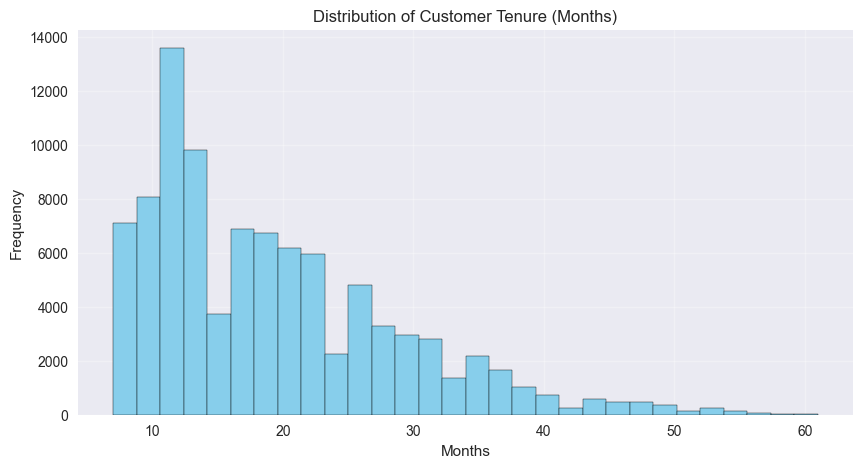

Tenure distribution plot saved to 'figures/tenure_distribution.png'


In [59]:
# Check churn distribution
churn_counts = df['churn'].value_counts()
print(f"\nChurn distribution:\n{churn_counts}")
print(f"Churn rate: {churn_counts[1] / len(df):.2%}")

# Visualize months distribution
plt.figure(figsize=(10, 5))
plt.hist(df['months'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Customer Tenure (Months)')
plt.xlabel('Months')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.savefig('figures/tenure_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("Tenure distribution plot saved to 'figures/tenure_distribution.png'")

# Variable Selection

In [60]:
df['churn'] = df['churn'].astype(int)


In [61]:
# Example: Using Label Encoding on categorical columns
from sklearn.preprocessing import LabelEncoder

df_encoded = df.copy()
for col in df_encoded.select_dtypes(include=['object']).columns:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))

corr_matrix = df_encoded.corr()

#corr_matrix = df.select_dtypes(include=['number']).corr()

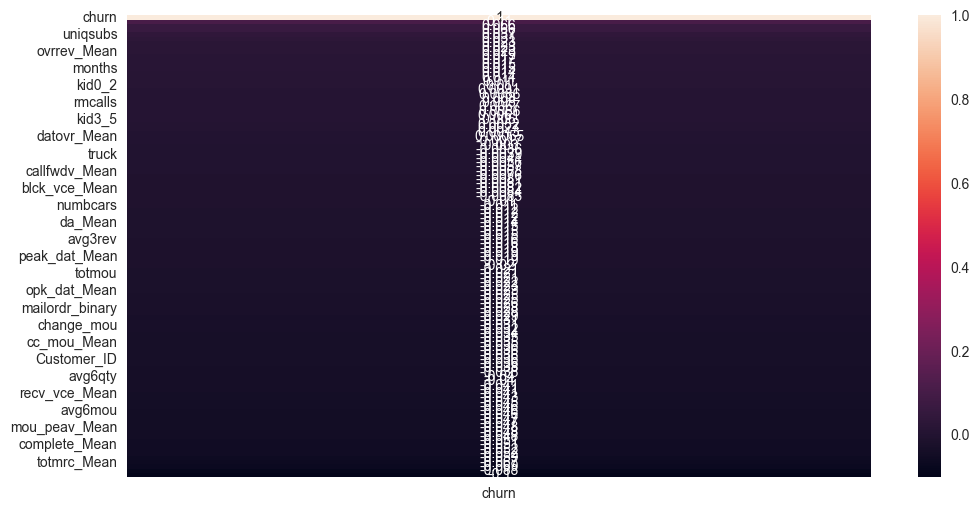

In [62]:

sns.heatmap(corr_matrix[['churn']].sort_values(by='churn', ascending=False), annot=True)
plt.show()


### Random Forest for Variable Selection


In [63]:
import pandas as pd
# import time
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.feature_selection import RFE



# # Separate target
# y = df['churn'].astype(int)

# # Drop target from features
# X = df.drop(columns=['churn'])

# # One-hot encode categorical features
# X_encoded = pd.get_dummies(X, drop_first=True)
# print(f"Encoded feature shape: {X_encoded.shape}")

# # Initialize timer log
# timestamps = []

# # Start overall timing
# start = time.time()

# # Define model
# model = RandomForestClassifier(n_estimators=10, random_state=42)
# print("Model initialized")
# timestamps.append(("Model init", time.time() - start))

# # Initialize RFE
# rfe = RFE(model, n_features_to_select=20)
# print("RFE initialized")
# timestamps.append(("RFE init", time.time() - start))

# # Fit RFE
# rfe.fit(X_encoded, y)
# print("RFE fitting complete")
# timestamps.append(("RFE fit", time.time() - start))

# # Get selected features
# selected_features = X_encoded.columns[rfe.support_]
# print("\nSelected features:")
# print(selected_features)
# timestamps.append(("Features selected", time.time() - start))

# # Print time log
# print("\nTiming breakdown:")
# for step, t in timestamps:
#     print(f"{step}: {t:.2f} seconds")


In [64]:
#X_encoded.to_csv("X_encoded.csv")
#X_encoded.to_csv("X_encoded.csv")
#X_encoded.to_csv("X_encoded.csv")
#Encoded feature shape: (93893, 980)
# Model initialized
# RFE initialized
# RFE fitting complete

# Selected features:
# Index(['rev_Mean', 'mou_Mean', 'change_mou', 'change_rev', 'mou_cvce_Mean',
#        'mouowylisv_Mean', 'mou_peav_Mean', 'mou_opkv_Mean', 'totcalls',
#        'totmou', 'totrev', 'adjrev', 'adjqty', 'avgrev', 'avgmou', 'avgqty',
#        'avg3qty', 'avg6mou', 'eqpdays', 'Customer_ID'],
#       dtype='object')

# Timing breakdown:
# Model init: 0.00 seconds
# RFE init: 0.00 seconds
# RFE fit: 10852.33 seconds
# Features selected: 10852.48 seconds

## Final Variable Selected

In [69]:
def explain_variable_selection(df):
    """
    Select and explain the rationale for choosing specific variables for survival analysis.
    """
    print("VARIABLE SELECTION EXPLANATION")
    print("-" * 50)
    
    # Customer identification variables
    id_vars = [ 'area'] #, 'csa', 'customer_id',
    print(f"Customer Identification Variables: {id_vars}")
    print("Rationale: These variables help identify and group customers geographically.")
    
    # Dependent variable: Tenure (duration until churn)
    duration_var = 'months'
    print(f"\nDuration Variable: {duration_var}")
    print("Rationale: Represents customer tenure - the time dimension in survival analysis.")
    
    # Event indicator: Churn
    event_var = 'churn'
    print(f"\nEvent Variable: {event_var}")
    print("Rationale: Binary indicator of whether a customer has churned (event occurred) or not (censored).")
    
    # Key predictor variables with business relevance
    predictor_vars = [
        'totmou',               # Total minutes of use
        'totrev',               # Total revenue
        'avgrev',               # Average monthly revenue
        'avgmou',               # Average monthly minutes of use
        'new_cell',             # New customer indicator
        'asl_flag',             # Account spending limit flag
        'dualband',             # Technology adoption
        'rev_Mean',             # Mean revenue
        'mou_Mean',             # Mean minutes of use
        'change_mou',           # Change in minutes of use
        'change_rev',           # Change in revenue
        'mou_cvce_Mean',        # Mean usage on cvce calls
        'mouowylisv_Mean',      # Mean off-peak weekend usage
        'mou_peav_Mean',        # Mean usage on peav calls
        'mou_opkv_Mean',        # Mean usage on opkv calls
        'totcalls',             # Total number of calls
        'adjrev',               # Adjusted revenue
        'adjqty',               # Adjusted quantity
        'avgqty',               # Average quantity
        'avg3qty',              # 3-month average quantity
        'avg6mou',              # 6-month average minutes of use
        'eqpdays'               # Equipment days
    ]


    
    print("\nKey Predictor Variables:")
    
    print("Usage-related Variables:")
    print("- totmou: Total minutes of use")
    print("  Rationale: Direct indicator of service usage intensity.")
    print("- avgmou: Average monthly minutes of use")
    print("  Rationale: Indicates consistent usage patterns.")
    
    print("\nRevenue-related Variables:")
    print("- totrev: Total revenue")
    print("  Rationale: Direct business impact measure.")
    print("- avgrev: Average monthly revenue")
    print("  Rationale: Indicates customer value and spending consistency.")
    
    print("\nService Quality Variables:")
    print("- drop_blk_Range: Call quality metric")
    print("  Rationale: Poor service experience is a key churn driver.")
    
    print("\nCustomer Profile Variables:")
    print("- new_cell: New customer indicator")
    print("  Rationale: New customers often have different churn patterns.")
    print("- asl_flag: Account spending limit flag")
    print("  Rationale: Credit risk indicator that may affect retention.")
    print("- prizm_social_one: Demographic segment")
    print("  Rationale: Demographic factors influence customer behavior and loyalty.")
    print("- dualband: Technology adoption")
    print("  Rationale: Technology adopters may have different engagement and loyalty.")
    
    # Return the selected variables for further analysis
    selected_vars = id_vars + [duration_var, event_var] + predictor_vars
    return selected_vars, duration_var, event_var, predictor_vars

selected_vars, duration_var, event_var, predictor_vars = explain_variable_selection(df)
    


VARIABLE SELECTION EXPLANATION
--------------------------------------------------
Customer Identification Variables: ['area']
Rationale: These variables help identify and group customers geographically.

Duration Variable: months
Rationale: Represents customer tenure - the time dimension in survival analysis.

Event Variable: churn
Rationale: Binary indicator of whether a customer has churned (event occurred) or not (censored).

Key Predictor Variables:
Usage-related Variables:
- totmou: Total minutes of use
  Rationale: Direct indicator of service usage intensity.
- avgmou: Average monthly minutes of use
  Rationale: Indicates consistent usage patterns.

Revenue-related Variables:
- totrev: Total revenue
  Rationale: Direct business impact measure.
- avgrev: Average monthly revenue
  Rationale: Indicates customer value and spending consistency.

Service Quality Variables:
- drop_blk_Range: Call quality metric
  Rationale: Poor service experience is a key churn driver.

Customer Profil

# Censoring Explanation


CENSORING APPROACH EXPLANATION
--------------------------------------------------
Total observations: 93893
Uncensored (churned) observations: 46716 (49.75%)
Right-censored observations: 47177 (50.25%)

Definition of Censoring in this Analysis:
- Event (churn=1): Customer has terminated service within the observation period.
- Right-censored (churn=0): Customer was still active at the end of the observation period.

Importance of Censoring:
- Right-censoring accounts for customers who haven't experienced the event by the
  end of the observation period but might do so in the future.
- Ignoring censoring would underestimate survival probabilities and lead to
  biased conclusions about customer lifetime.
- Survival analysis methods like Kaplan-Meier and parametric models properly
  account for censored observations in estimating survival functions.


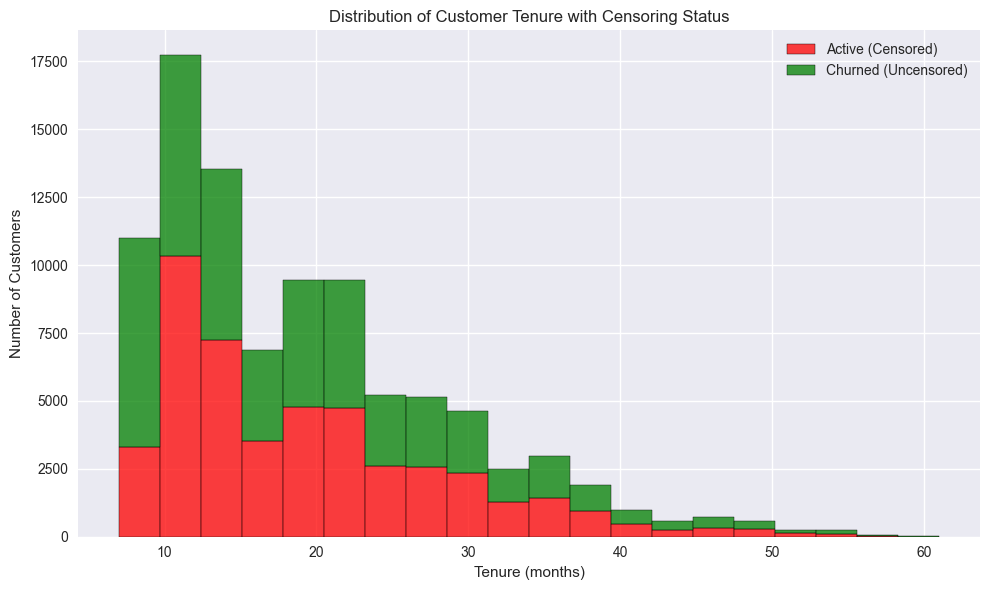

In [66]:
def explain_censoring_approach(df):
    """
    Provide a detailed explanation of the censoring approach used in the survival analysis.
    """
    print("\nCENSORING APPROACH EXPLANATION")
    print("-" * 50)
    
    # Count censored and uncensored observations
    censored_count = sum(df['churn'] == 0)
    uncensored_count = sum(df['churn'] == 1)
    total_count = len(df)
    
    print(f"Total observations: {total_count}")
    print(f"Uncensored (churned) observations: {uncensored_count} ({uncensored_count/total_count*100:.2f}%)")
    print(f"Right-censored observations: {censored_count} ({censored_count/total_count*100:.2f}%)")
    
    print("\nDefinition of Censoring in this Analysis:")
    print("- Event (churn=1): Customer has terminated service within the observation period.")
    print("- Right-censored (churn=0): Customer was still active at the end of the observation period.")
    
    print("\nImportance of Censoring:")
    print("- Right-censoring accounts for customers who haven't experienced the event by the")
    print("  end of the observation period but might do so in the future.")
    print("- Ignoring censoring would underestimate survival probabilities and lead to")
    print("  biased conclusions about customer lifetime.")
    print("- Survival analysis methods like Kaplan-Meier and parametric models properly")
    print("  account for censored observations in estimating survival functions.")
    
    # Create a visualization of censoring
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='months', hue='churn', bins=20, 
                 multiple='stack', palette=['green', 'red'])
    plt.xlabel('Tenure (months)')
    plt.ylabel('Number of Customers')
    plt.title('Distribution of Customer Tenure with Censoring Status')
    plt.legend(['Active (Censored)', 'Churned (Uncensored)'])
    plt.tight_layout()
    plt.savefig('censoring_visualization.png')
    plt.show()
    plt.close()
    


explain_censoring_approach(df)
    


# Kaplan-Meier Survival Analysis

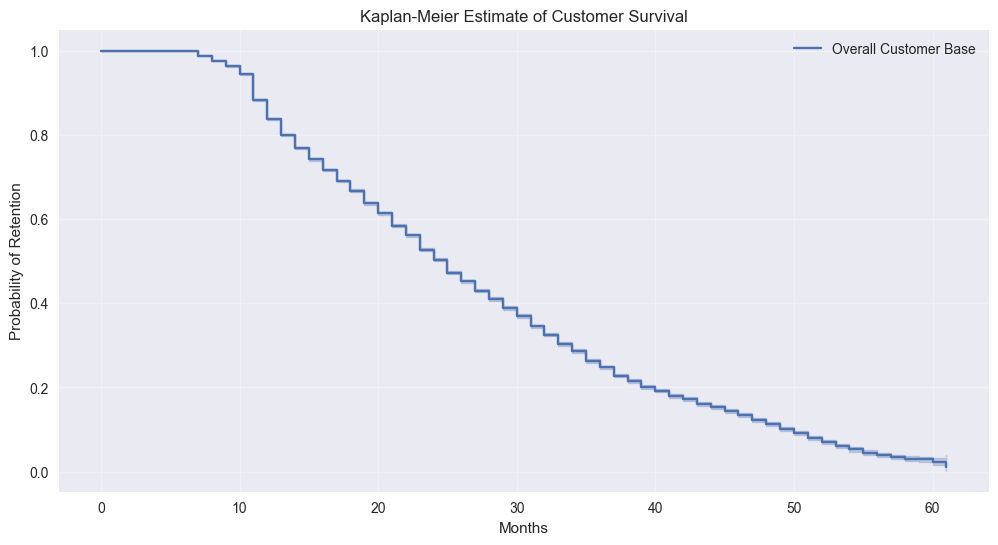

Overall survival curve saved to 'figures/overall_survival_curve.png'

Survival function (first 5 rows):


,Overall Customer Base
timeline,
0.0,1.000000
7.0,0.988146
8.0,0.976214
9.0,0.963741
10.0,0.944304
11.0,0.883816
12.0,0.838765
13.0,0.800153
14.0,0.769193



Confidence intervals (first 5 rows):


,Overall Customer Base_lower_0.95,Overall Customer Base_upper_0.95
0.0,1.000000,1.000000
7.0,0.987433,0.988819
8.0,0.975213,0.977176
9.0,0.962508,0.964934
10.0,0.942780,0.945789
11.0,0.881655,0.885940
12.0,0.836262,0.841233
13.0,0.797408,0.802865
14.0,0.766278,0.772078
15.0,0.739100,0.745175


In [9]:
# Instantiate the KaplanMeierFitter
kmf = KaplanMeierFitter()

# Fit the model
# 'months' is our duration column
# 'churn' is our event indicator (1 = churned, 0 = still active/censored)
kmf.fit(df['months'], df['churn'], label='Overall Customer Base')

# Plot the survival function
plt.figure(figsize=(12, 6))
kmf.plot_survival_function()
plt.title('Kaplan-Meier Estimate of Customer Survival')
plt.xlabel('Months')
plt.ylabel('Probability of Retention')
plt.grid(alpha=0.3)
plt.savefig('figures/overall_survival_curve.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("Overall survival curve saved to 'figures/overall_survival_curve.png'")

# Survival function
print("\nSurvival function (first 5 rows):")
display(kmf.survival_function_)

# Confidence intervals
print("\nConfidence intervals (first 5 rows):")
display(kmf.confidence_interval_)

# Stratified Analysis by Customer Segments

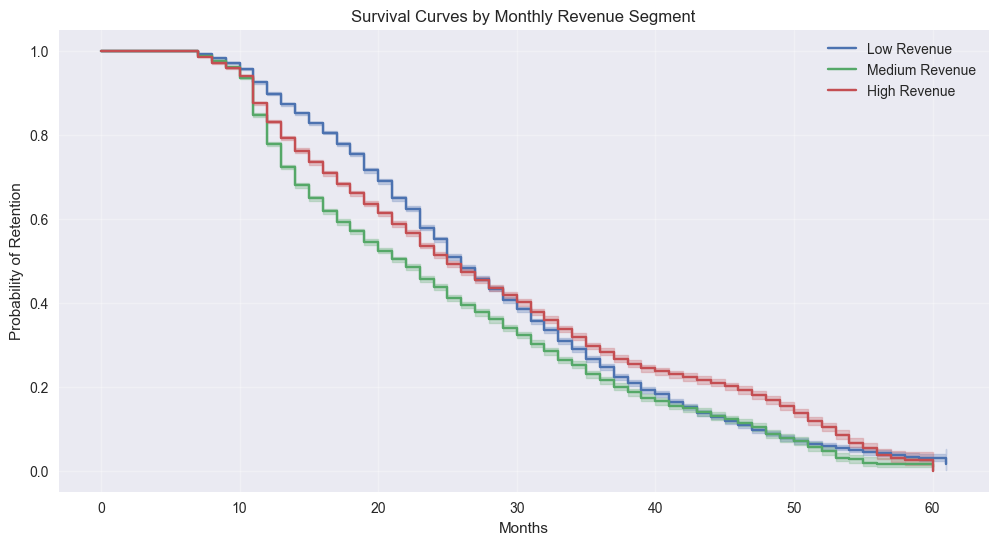

Revenue segment survival curves saved to 'figures/revenue_segment_survival.png'


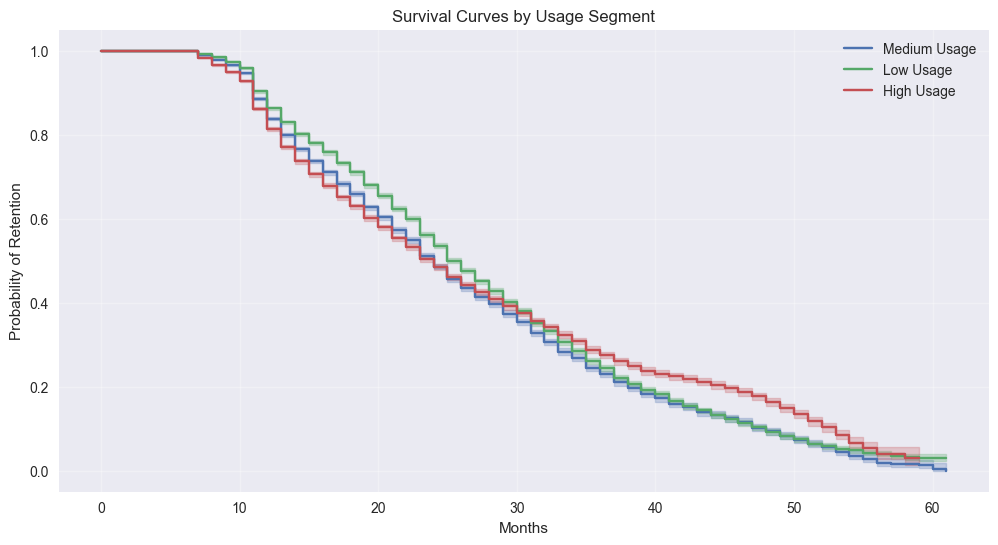

Usage segment survival curves saved to 'figures/usage_segment_survival.png'


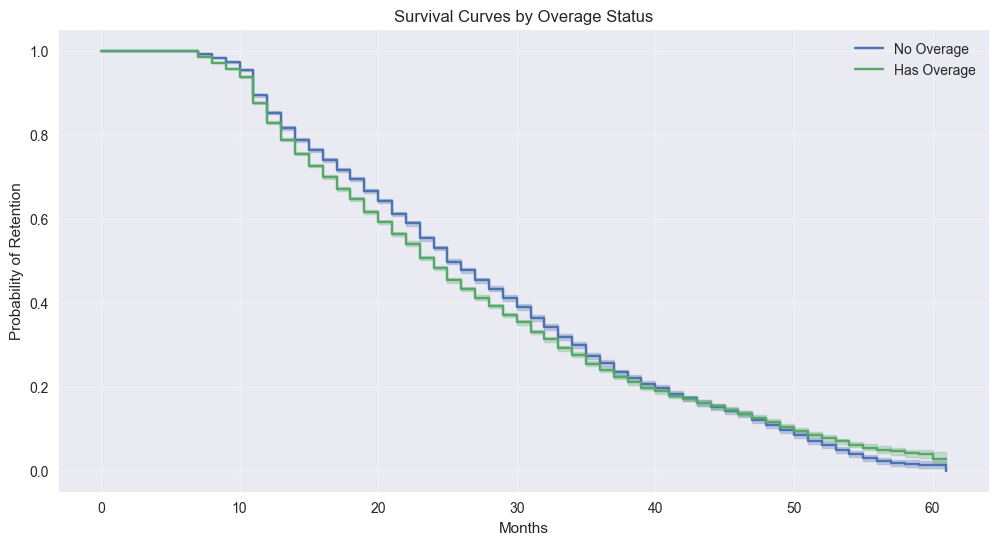

Overage status survival curves saved to 'figures/overage_survival.png'

Logrank test results for Low vs High Revenue:
p-value: 0.0000
Logrank test results for No Overage vs Has Overage:
p-value: 0.0000


In [10]:
# 4.1 Segment by Monthly Revenue (totmrc_Mean)
# Create high and low value customer segments
df['revenue_segment'] = pd.qcut(df['totmrc_Mean'], 3, labels=['Low', 'Medium', 'High'])

# Plot survival curves by revenue segment
plt.figure(figsize=(12, 6))

for segment in df['revenue_segment'].unique():
    segment_mask = (df['revenue_segment'] == segment)
    durations = df.loc[segment_mask, 'months']
    events = df.loc[segment_mask, 'churn']
    
    if durations.empty or events.empty:
        continue

    kmf = KaplanMeierFitter()
    kmf.fit(durations, events, label=f'{segment} Revenue')
    kmf.plot_survival_function()


plt.title('Survival Curves by Monthly Revenue Segment')
plt.xlabel('Months')
plt.ylabel('Probability of Retention')
plt.grid(alpha=0.3)
plt.savefig('figures/revenue_segment_survival.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("Revenue segment survival curves saved to 'figures/revenue_segment_survival.png'")

# 4.2 Segment by Minutes of Use (mou_Mean)
df['usage_segment'] = pd.qcut(df['mou_Mean'], 3, labels=['Low', 'Medium', 'High'])

# Plot survival curves by usage segment
plt.figure(figsize=(12, 6))

for segment in df['usage_segment'].dropna().unique():
    segment_mask = (df['usage_segment'] == segment)
    durations = df.loc[segment_mask, 'months']
    events = df.loc[segment_mask, 'churn']

    # Skip if durations or events are empty or non-numeric
    if durations.empty or events.empty:
        print(f"Skipping segment '{segment}' — no data.")
        continue
    if not np.issubdtype(durations.dtype, np.number) or not np.issubdtype(events.dtype, np.number):
        print(f"Skipping segment '{segment}' — non-numeric data.")
        continue

    kmf = KaplanMeierFitter()
    kmf.fit(durations, events, label=f'{segment} Usage')
    kmf.plot_survival_function()

plt.title('Survival Curves by Usage Segment')
plt.xlabel('Months')
plt.ylabel('Probability of Retention')
plt.grid(alpha=0.3)
plt.savefig('figures/usage_segment_survival.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("Usage segment survival curves saved to 'figures/usage_segment_survival.png'")

# 4.3 Segment by Overage Minutes (ovrmou_Mean)
# First, categorize customers into those with overage and those without
df['has_overage'] = (df['ovrmou_Mean'] > 0).astype(int)

# Plot survival curves by overage status
plt.figure(figsize=(12, 6))

# For customers with no overage
kmf_no_overage = KaplanMeierFitter()
mask_no_overage = (df['has_overage'] == 0)
kmf_no_overage.fit(df.loc[mask_no_overage, 'months'],
                  df.loc[mask_no_overage, 'churn'],
                  label='No Overage')
kmf_no_overage.plot_survival_function()

# For customers with overage
kmf_overage = KaplanMeierFitter()
mask_overage = (df['has_overage'] == 1)
kmf_overage.fit(df.loc[mask_overage, 'months'],
               df.loc[mask_overage, 'churn'],
               label='Has Overage')
kmf_overage.plot_survival_function()

plt.title('Survival Curves by Overage Status')
plt.xlabel('Months')
plt.ylabel('Probability of Retention')
plt.grid(alpha=0.3)
plt.savefig('figures/overage_survival.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("Overage status survival curves saved to 'figures/overage_survival.png'")

# Perform logrank test to compare groups
# Revenue segments
low_rev = df[df['revenue_segment'] == 'Low']
high_rev = df[df['revenue_segment'] == 'High']

results = logrank_test(low_rev['months'], high_rev['months'], 
                     low_rev['churn'], high_rev['churn'])
print("\nLogrank test results for Low vs High Revenue:")
print(f"p-value: {results.p_value:.4f}")

# Overage status
no_overage = df[df['has_overage'] == 0]
has_overage = df[df['has_overage'] == 1]

results = logrank_test(no_overage['months'], has_overage['months'], 
                     no_overage['churn'], has_overage['churn'])
print("Logrank test results for No Overage vs Has Overage:")
print(f"p-value: {results.p_value:.4f}")

In [18]:
df['income']

0        5.0
1        6.0
2        6.0
3        9.0
4        9.0
        ... 
54697    3.0
54698    6.0
54699    6.0
54700    7.0
54701    2.0
Name: income, Length: 54702, dtype: float64

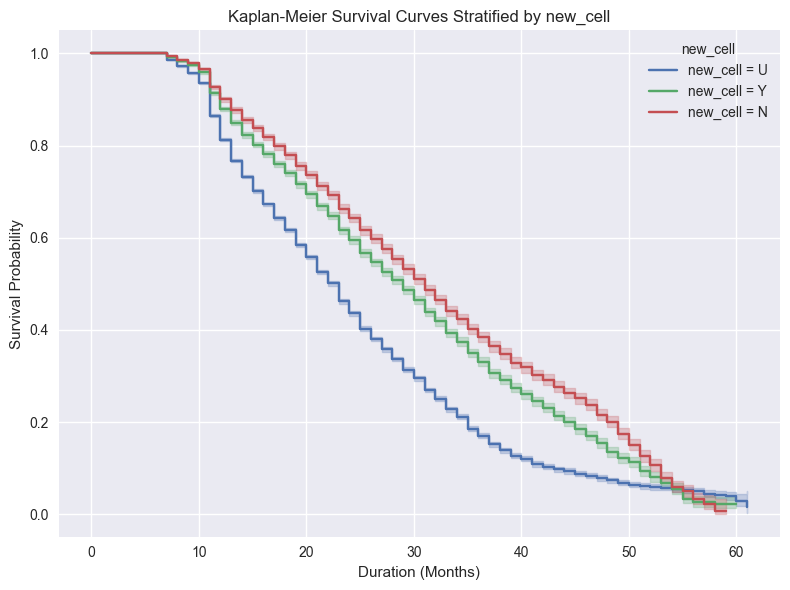

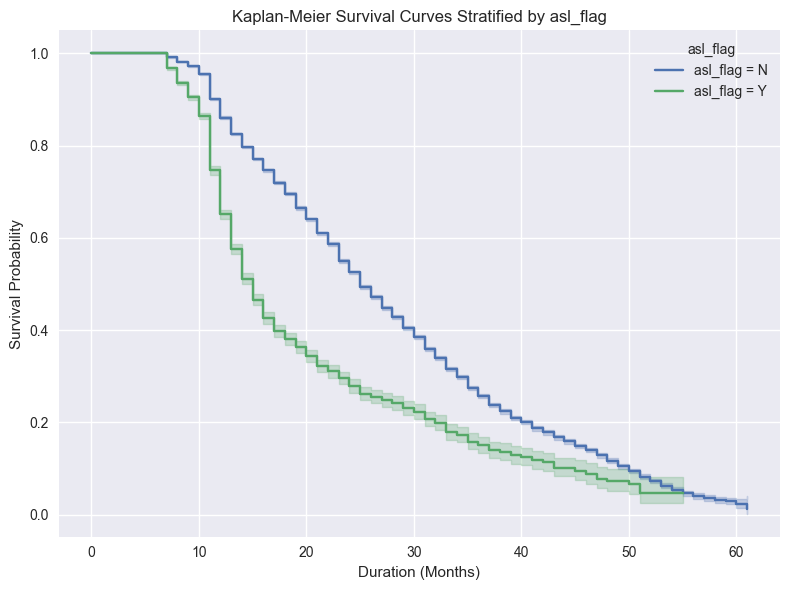

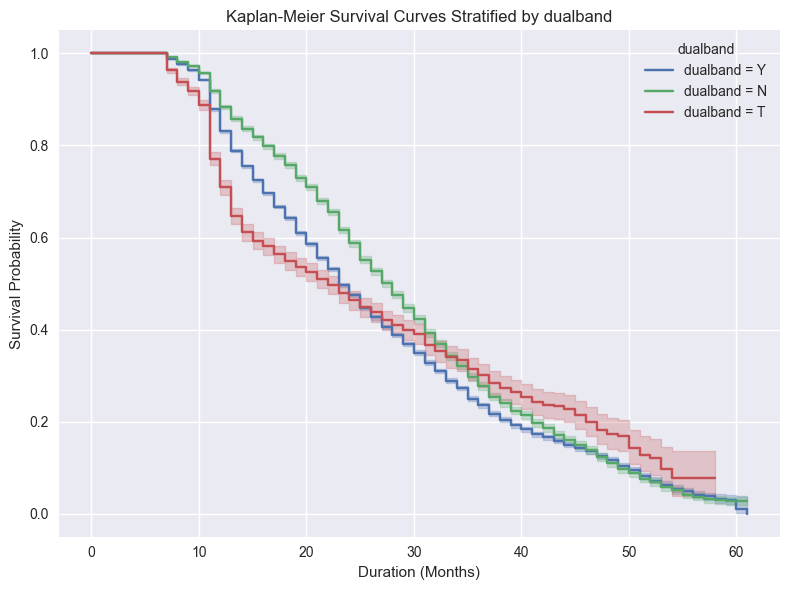

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Initialize Kaplan-Meier Fitter
kmf = KaplanMeierFitter()

# Define duration and event columns
duration_col = 'months'
event_col = 'churn'

# Define categorical stratification variables
stratification_vars = ['new_cell', 'asl_flag',  'dualband']

# Plot KMF curves stratified by each variable
for var in stratification_vars:
    plt.figure(figsize=(8, 6))
    for level in df[var].dropna().unique():
        mask = df[var] == level
        kmf.fit(df.loc[mask, duration_col], df.loc[mask, event_col], label=f"{var} = {level}")
        kmf.plot_survival_function(ci_show=True)
    
    plt.title(f"Kaplan-Meier Survival Curves Stratified by {var}")
    plt.xlabel("Duration (Months)")
    plt.ylabel("Survival Probability")
    plt.legend(title=var)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [23]:
df['income_bin'] = pd.cut(df['income'], bins=3, labels=['Low Income', 'Mid Income', 'High Income'])
df['hnd_price_bin'] = pd.qcut(df['hnd_price'], q=3, labels=['Budget', 'Midrange', 'Premium'])
df['eqp_age_bin'] = pd.qcut(df['eqpdays'], q=3, labels=['New', 'Medium', 'Old'])
df['usage_bin'] = pd.cut(df['avg3mou'], bins=4, labels=['Very Low', 'Low', 'High', 'Very High'])



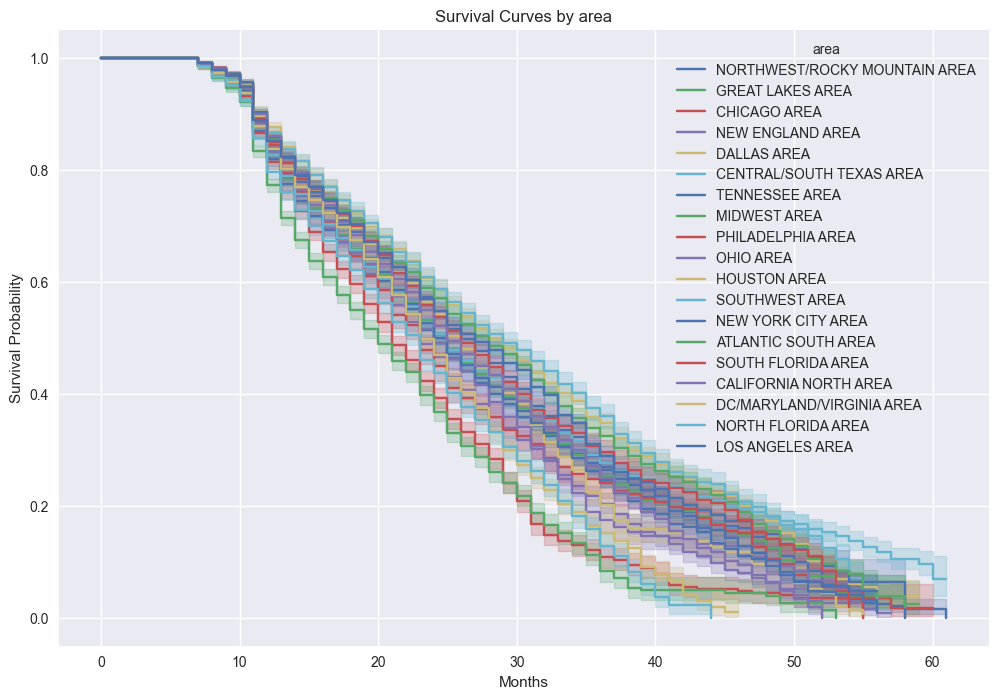

    rank                           area  survival_probability
2    1.0                   CHICAGO AREA              0.207771
13   2.0            ATLANTIC SOUTH AREA              0.217378
16   3.0      DC/MARYLAND/VIRGINIA AREA              0.272748
17   4.0             NORTH FLORIDA AREA              0.279914
3    5.0               NEW ENGLAND AREA              0.316804
8    6.0              PHILADELPHIA AREA              0.324251
9    7.0                      OHIO AREA              0.340061
0    8.0  NORTHWEST/ROCKY MOUNTAIN AREA              0.358489
12   9.0             NEW YORK CITY AREA              0.369248
1   10.0               GREAT LAKES AREA              0.374772
10  11.0                   HOUSTON AREA              0.381155
15  12.0          CALIFORNIA NORTH AREA              0.387713
11  13.0                 SOUTHWEST AREA              0.397571
14  14.0             SOUTH FLORIDA AREA              0.398647
6   15.0                 TENNESSEE AREA              0.407704
18  16.0

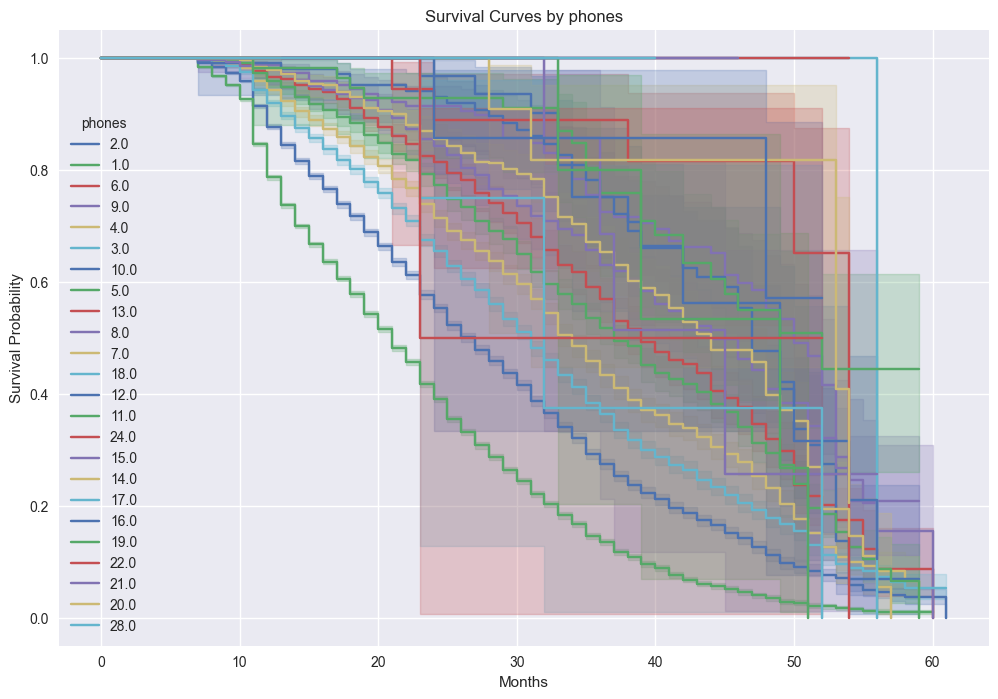

    rank  phones  survival_probability
1    1.0     1.0              0.244140
0    2.0     2.0              0.415514
20   3.0    22.0              0.500000
5    4.0     3.0              0.510144
4    5.0     4.0              0.596190
7    6.0     5.0              0.648871
2    7.0     6.0              0.704981
9    8.0     8.0              0.735198
17   9.0    17.0              0.750000
10  10.0     7.0              0.792800
3   11.0     9.0              0.856875
18  12.0    16.0              0.857143
6   13.0    10.0              0.871636
8   14.0    13.0              0.888889
16  15.0    14.0              0.909091
13  16.0    11.0              0.909621
12  17.0    12.0              0.935484
15  18.0    15.0              1.000000
11  18.0    18.0              1.000000
14  18.0    24.0              1.000000
19  18.0    19.0              1.000000
21  18.0    21.0              1.000000
22  18.0    20.0              1.000000
23  18.0    28.0              1.000000


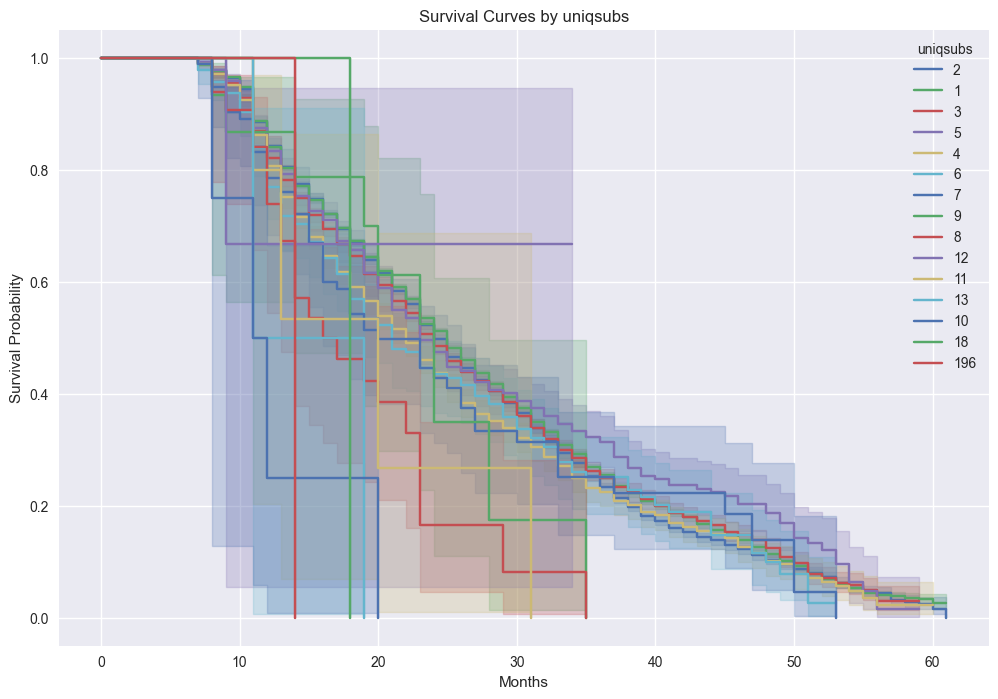

    rank  uniqsubs  survival_probability
12   1.0        10              0.000000
13   1.0        18              0.000000
14   1.0       196              0.000000
11   1.0        13              0.000000
8    5.0         8              0.082367
7    6.0         9              0.175084
10   7.0        11              0.266667
6    8.0         7              0.313422
4    9.0         4              0.321712
5   10.0         6              0.336823
2   11.0         3              0.360777
0   12.0         2              0.366393
1   13.0         1              0.373623
3   14.0         5              0.386310
9   15.0        12              0.666667


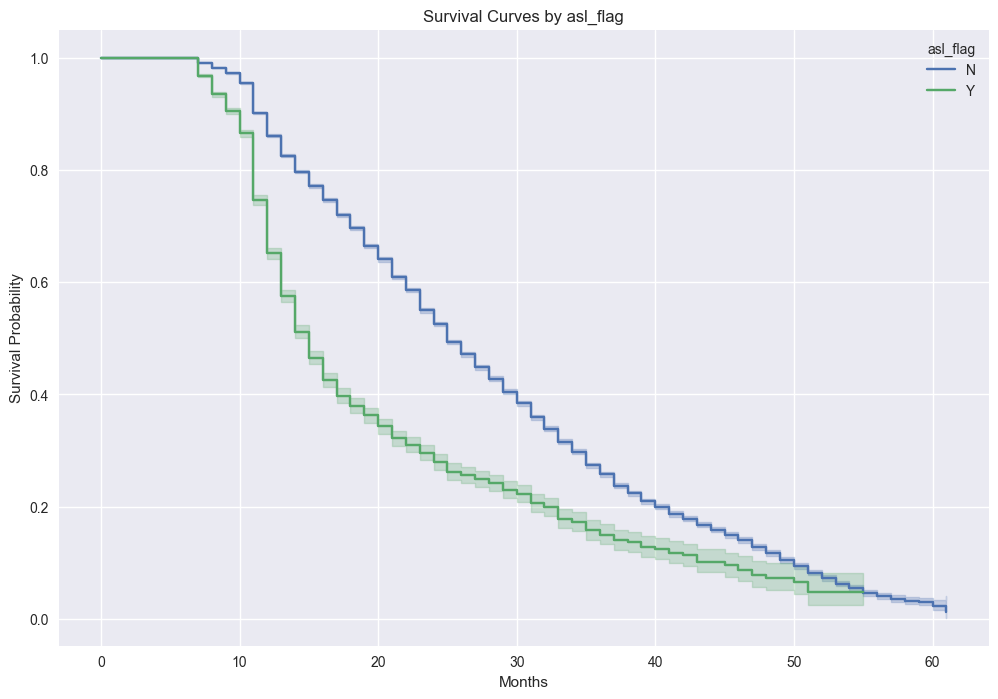

   rank asl_flag  survival_probability
1   1.0        Y              0.223155
0   2.0        N              0.384553


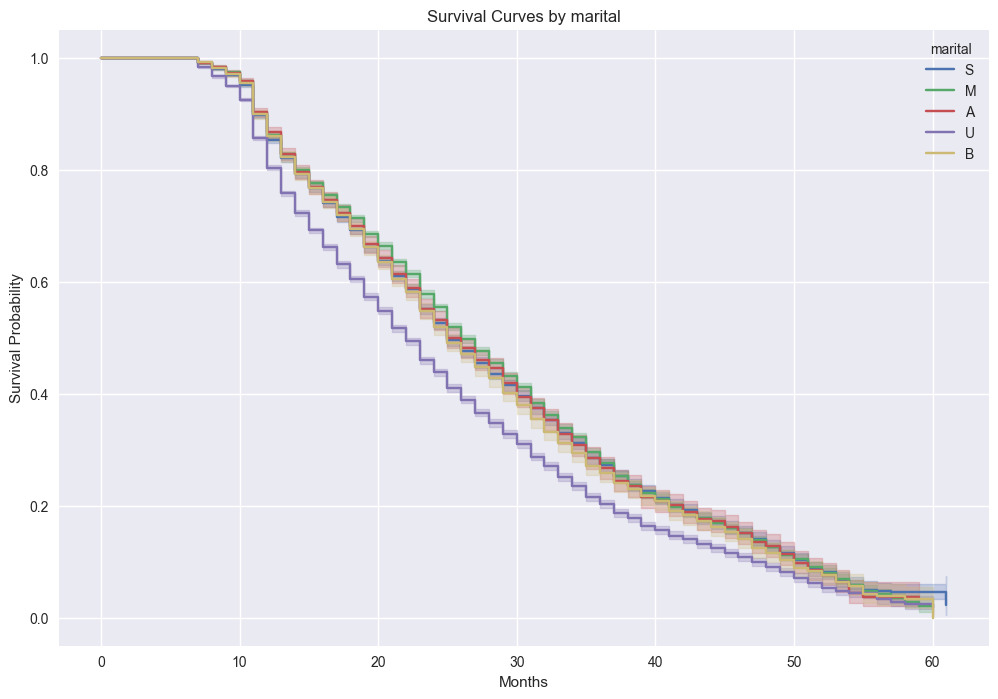

   rank marital  survival_probability
3   1.0       U              0.310417
4   2.0       B              0.379354
2   3.0       A              0.394680
0   4.0       S              0.396575
1   5.0       M              0.411404


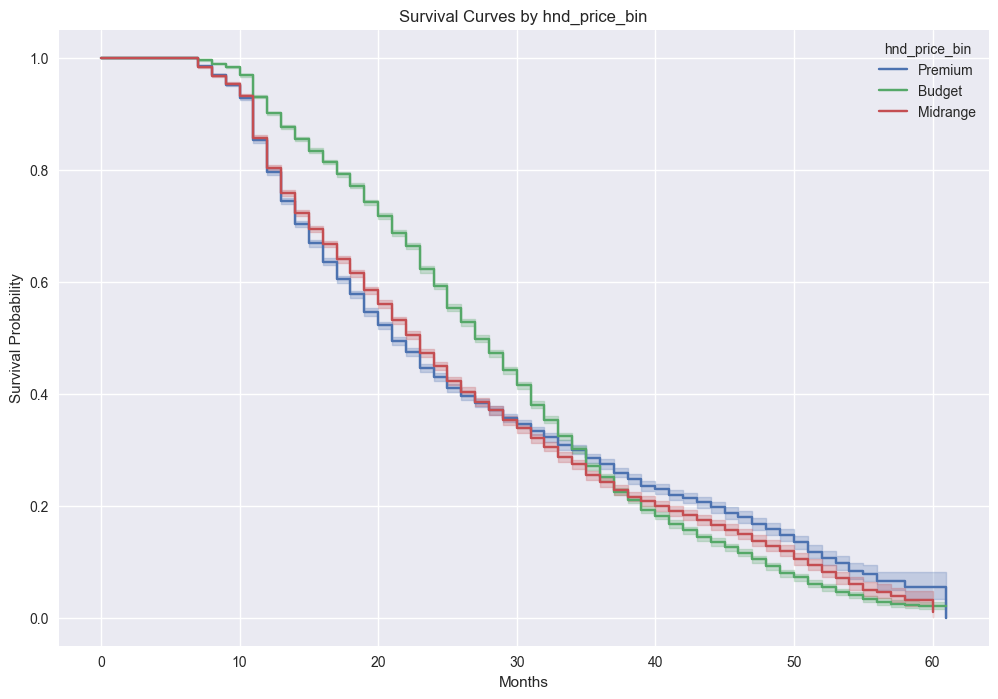

   rank hnd_price_bin  survival_probability
2   1.0      Midrange              0.338503
0   2.0       Premium              0.345915
1   3.0        Budget              0.415100


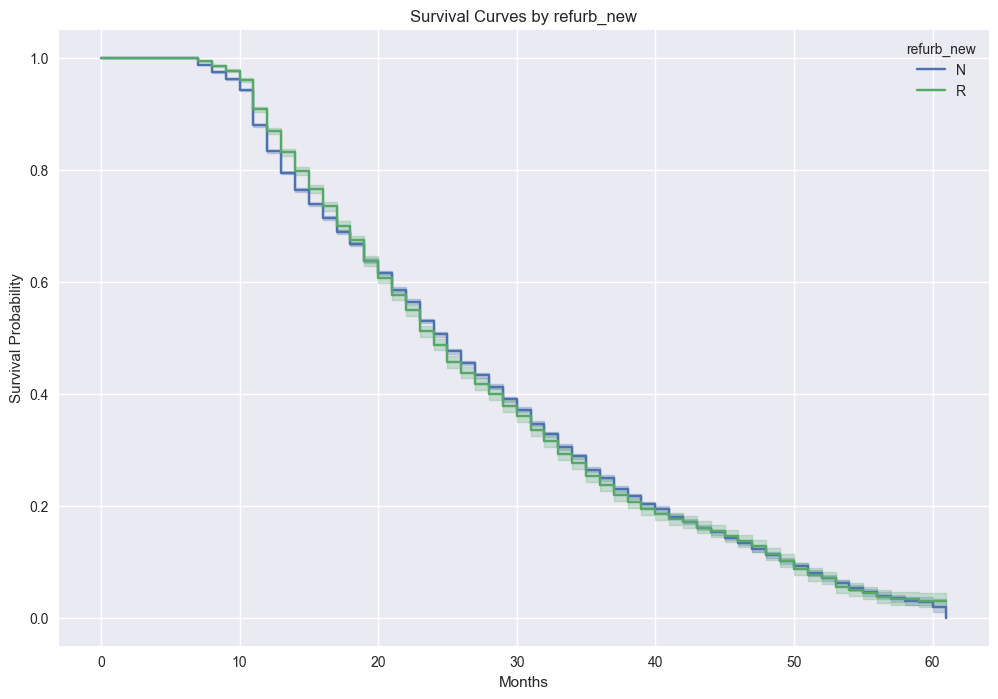

   rank refurb_new  survival_probability
1   1.0          R              0.359673
0   2.0          N              0.371031


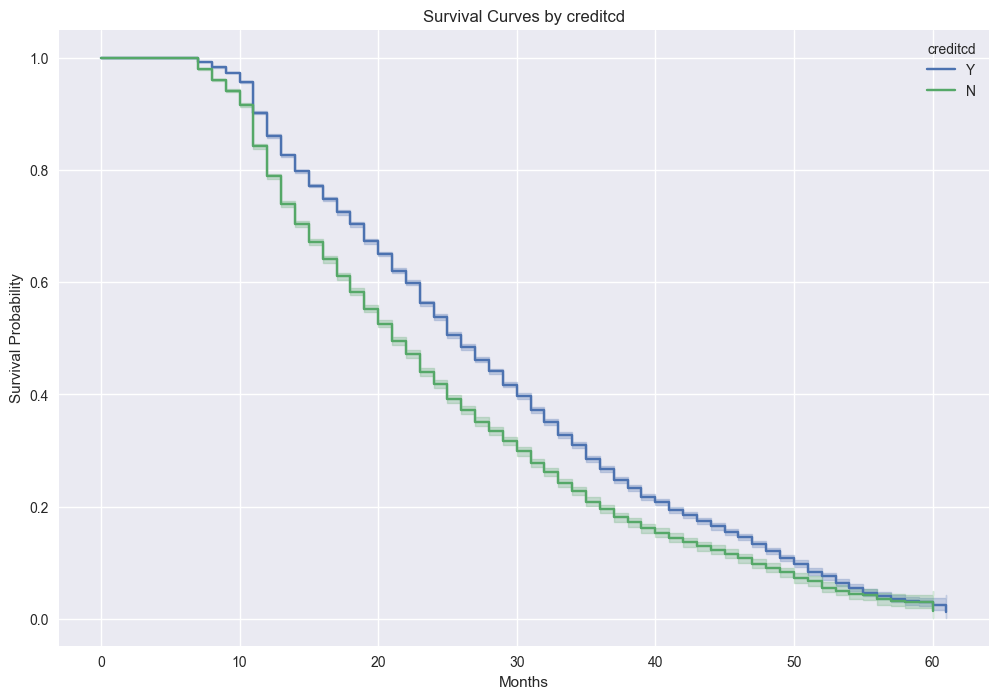

   rank creditcd  survival_probability
1   1.0        N              0.298817
0   2.0        Y              0.397790


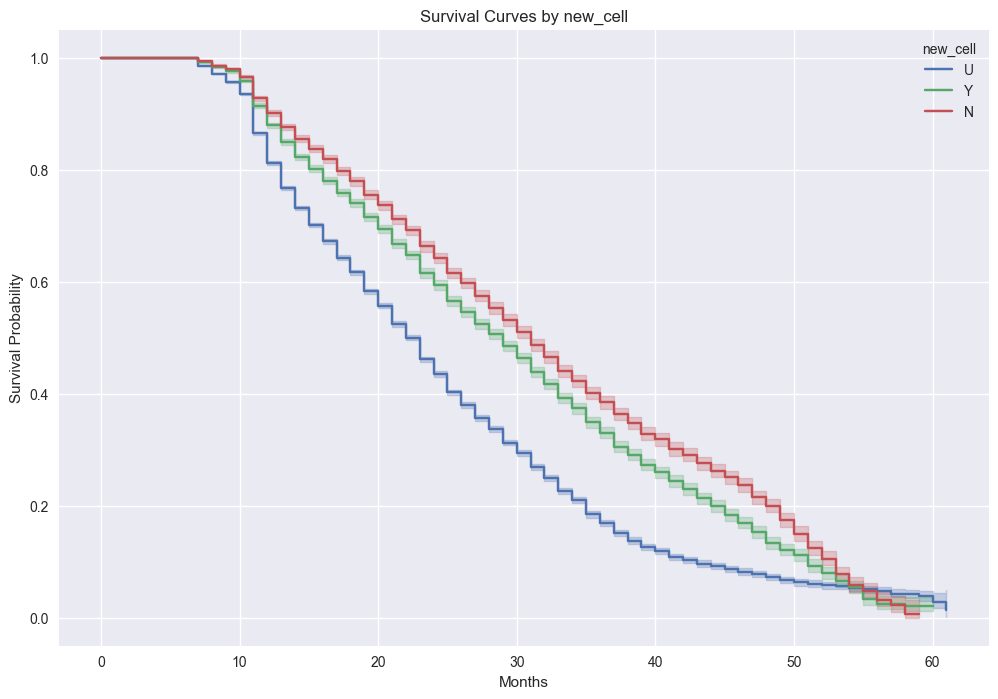

   rank new_cell  survival_probability
0   1.0        U              0.294933
1   2.0        Y              0.464639
2   3.0        N              0.510809


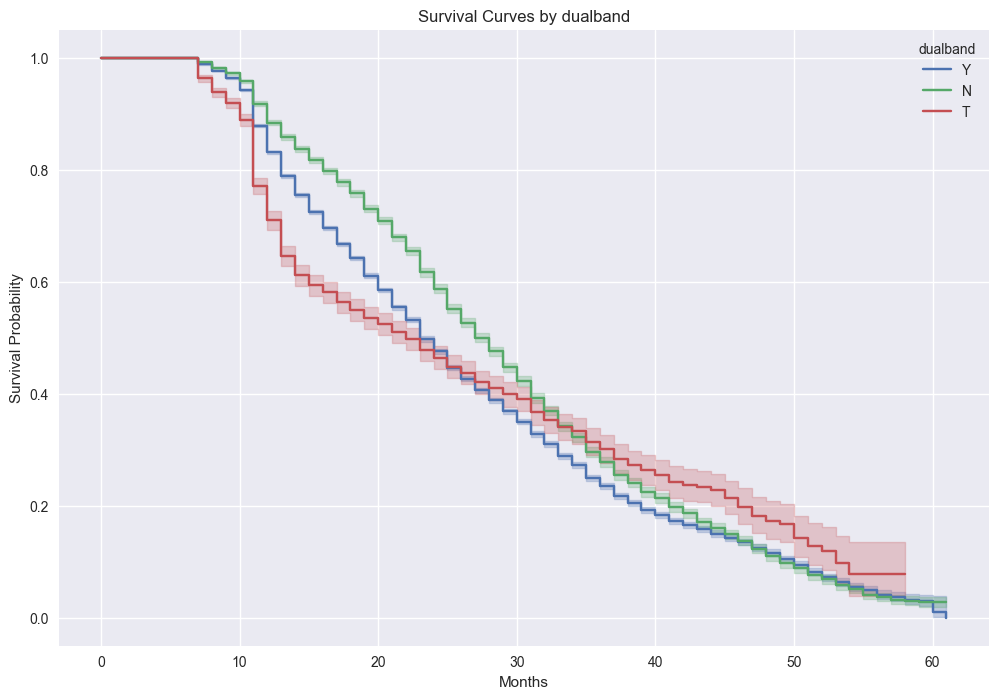

   rank dualband  survival_probability
0   1.0        Y              0.350230
2   2.0        T              0.390534
1   3.0        N              0.422843


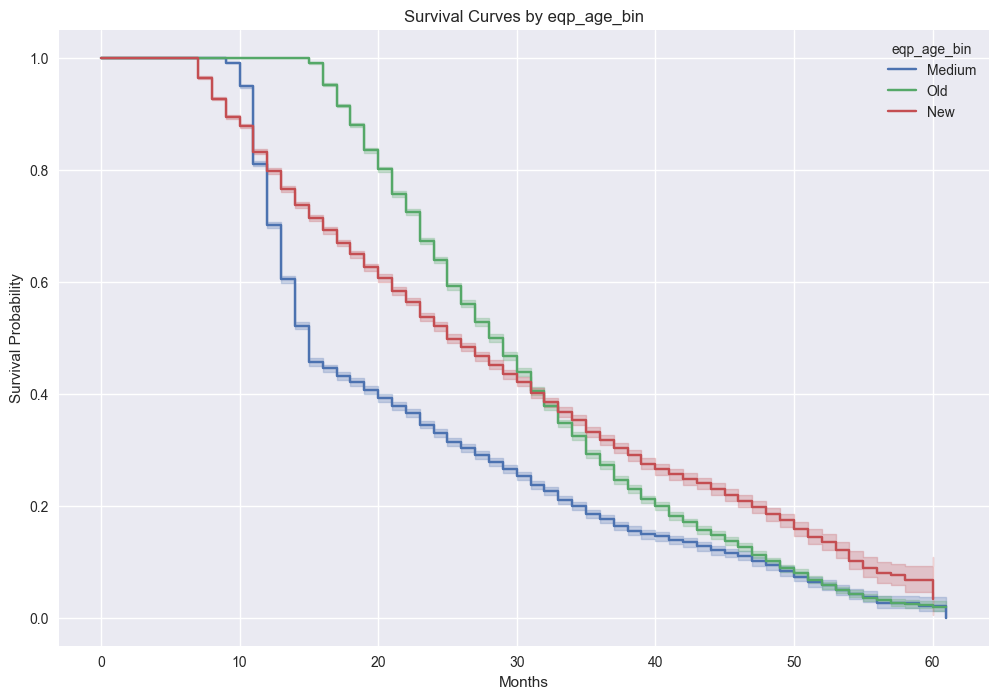

   rank eqp_age_bin  survival_probability
0   1.0      Medium              0.253224
2   2.0         New              0.421636
1   3.0         Old              0.438889


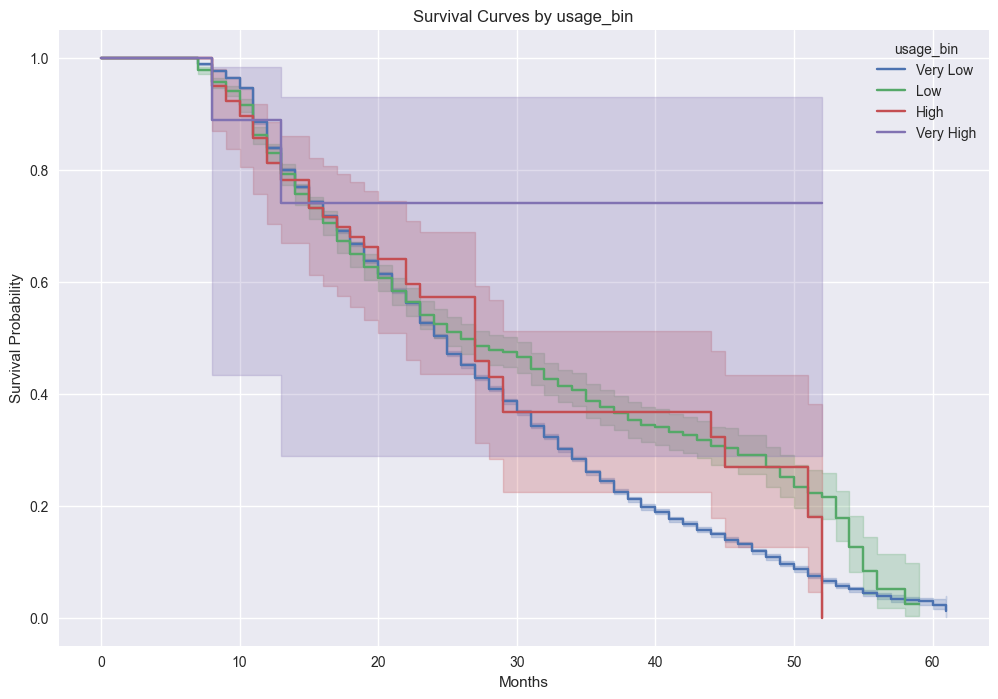

   rank  usage_bin  survival_probability
0   1.0   Very Low              0.367115
2   2.0       High              0.368247
1   3.0        Low              0.464909
3   4.0  Very High              0.740741


In [28]:
ssegmentation_vars = [
    'area',
    'phones',
    'uniqsubs',
    'asl_flag',
    'marital',
    'hnd_price_bin',     # Binned: Budget, Midrange, Premium
    'refurb_new',
    'creditcd',
    'new_cell',
    'dualband',
    'eqp_age_bin',       # Binned: <1 year, 1–2 years, 2+ years
    'usage_bin'          # Binned: Very Low, Low, High, Very High
]

for i in ssegmentation_vars:
    plt.figure(figsize=(12, 8))  

    for segment in df[i].dropna().unique():
        kmf.fit(df[df[i] == segment]['months'],
                df[df[i] == segment]['churn'],
                label=str(segment))
        kmf.plot_survival_function()

    plt.title(f'Survival Curves by {i}')
    plt.xlabel('Months')
    plt.ylabel('Survival Probability')
    plt.legend(title=f'{i}')
    plt.grid(True)
    plt.show()




    time_point = 30

    survival_probs_list = []

    for segment in df[i].dropna().unique():
        kmf.fit(df[df[i] == segment]['months'],
                df[df[i] == segment]['churn'],
                label=str(segment))
        survival_prob = kmf.survival_function_at_times([time_point]).iloc[0]
        survival_probs_list.append({f'{i}': segment, 'survival_probability': survival_prob})

    survival_probs = pd.DataFrame(survival_probs_list)

    survival_probs = survival_probs.sort_values(by='survival_probability', ascending=True)
    survival_probs['rank'] = survival_probs['survival_probability'].rank(method='min')

    print(survival_probs[['rank', f'{i}', 'survival_probability']])




# Parametric Survival Models

Shape after dropping missing values: (93893, 44)

Fitting Weibull AFT model...
Weibull AFT Model Summary:


coef  exp(coef)      se(coef)  \
param   covariate                                                               
lambda_ adjqty                             -0.000699   0.999301  1.902631e-05   
        adjrev                              0.001559   1.001560  2.297978e-05   
        area_CALIFORNIA NORTH AREA          0.026061   1.026404  7.127785e-03   
        area_CENTRAL/SOUTH TEXAS AREA       0.105112   1.110835  8.042563e-03   
        area_CHICAGO AREA                   0.024386   1.024686  7.432694e-03   
        area_DALLAS AREA                    0.078700   1.081880  7.394138e-03   
        area_DC/MARYLAND/VIRGINIA AREA      0.039970   1.040779  7.157769e-03   
        area_GREAT LAKES AREA               0.064593   1.066725  7.745346e-03   
        area_HOUSTON AREA                   0.055240   1.056794  7.981047e-03   
        area_LOS ANGELES AREA               0.171555   1.187150  7.176196e-03   
        area_MIDWEST AREA                   0.113638   1.120346  7.223576e-03   
        area_NEW ENGLAND AREA               0.026659   1.027018  7.270377e-03   
        area_NEW YORK CITY AREA             0.049457   1.050701  6.363486e-03   
        area_NORTH FLORIDA AREA             0.024866   1.025177  7.724053e-03   
        area_NORTHWEST/ROCKY MOUNTAIN AREA  0.035889   1.036540  7.564309e-03   
        area_OHIO AREA                      0.041004   1.041856  7.835938e-03   
        area_PHILADELPHIA AREA              0.021897   1.022139  9.331339e-03   
        area_SOUTH FLORIDA AREA             0.022616   1.022874  8.317745e-03   
        area_SOUTHWEST AREA                 0.226125   1.253732  7.250178e-03   
        area_TENNESSEE AREA                 0.058592   1.060343  9.232990e-03   
        asl_flag_Y                          0.019750   1.019947  4.320570e-03   
        avg3qty                            -0.000125   0.999875  2.441725e-05   
        avg6mou                             0.000164   1.000164  1.197620e-05   
        avgmou                             -0.000280   0.999720  1.818999e-05   
        avgqty                             -0.000049   0.999951  3.959274e-05   
        avgrev                             -0.006459   0.993562  8.699146e-05   
        change_mou                          0.000066   1.000066  6.427492e-06   
        change_rev                         -0.000281   0.999719  2.482682e-05   
        dualband_T                         -0.015776   0.984348  7.319606e-03   
        dualband_Y                         -0.037963   0.962749  3.082831e-03   
        eqpdays                             0.000247   1.000247  4.650284e-06   
        mou_Mean                            0.000079   1.000079  1.108428e-05   
        mou_cvce_Mean                       0.000020   1.000020  1.734837e-05   
        mou_opkv_Mean                       0.000014   1.000014  1.619264e-05   
        mou_peav_Mean                      -0.000036   0.999964  1.532083e-05   
        mouowylisv_Mean                    -0.000083   0.999917  3.477176e-05   
        new_cell_U                         -0.074310   0.928384  3.742576e-03   
        new_cell_Y                         -0.008820   0.991219  4.361143e-03   
        rev_Mean                           -0.000299   0.999701  4.956169e-05   
        totcalls                            0.000721   1.000721  1.903330e-05   
        totmou                             -0.000014   0.999986  9.619631e-07   
        totrev                             -0.000925   0.999075  2.207009e-05   
        Intercept                           2.956688  19.234157  7.470109e-03   
rho_    Intercept                           1.319746   3.742472  3.020179e-03   

                                            coef lower 95%  coef upper 95%  \
param   covariate                                                            
lambda_ adjqty                                   -0.000736       -0.000662   
        adjrev                                    0.001514        0.001604   
        a


Fitting Log-Logistic AFT model...
Log-Logistic AFT Model Summary:


coef  exp(coef)      se(coef)  \
param  covariate                                                               
alpha_ adjqty                             -0.000619   0.999381  1.514895e-05   
       adjrev                              0.001655   1.001657  2.280599e-05   
       area_CALIFORNIA NORTH AREA          0.017735   1.017893  5.397748e-03   
       area_CENTRAL/SOUTH TEXAS AREA       0.047710   1.048866  6.096660e-03   
       area_CHICAGO AREA                   0.010205   1.010257  5.584642e-03   
       area_DALLAS AREA                    0.038974   1.039744  5.595629e-03   
       area_DC/MARYLAND/VIRGINIA AREA      0.032330   1.032858  5.342203e-03   
       area_GREAT LAKES AREA               0.030927   1.031410  5.833739e-03   
       area_HOUSTON AREA                   0.041060   1.041915  6.012177e-03   
       area_LOS ANGELES AREA               0.082717   1.086234  5.534309e-03   
       area_MIDWEST AREA                   0.050825   1.052139  5.444367e-03   
       area_NEW ENGLAND AREA               0.019382   1.019571  5.483811e-03   
       area_NEW YORK CITY AREA             0.030837   1.031317  4.769522e-03   
       area_NORTH FLORIDA AREA             0.017553   1.017707  5.868785e-03   
       area_NORTHWEST/ROCKY MOUNTAIN AREA  0.008886   1.008926  5.812733e-03   
       area_OHIO AREA                      0.025051   1.025367  5.853934e-03   
       area_PHILADELPHIA AREA              0.014861   1.014971  7.048464e-03   
       area_SOUTH FLORIDA AREA             0.022079   1.022325  6.391513e-03   
       area_SOUTHWEST AREA                 0.040767   1.041610  5.470998e-03   
       area_TENNESSEE AREA                 0.036798   1.037484  7.001017e-03   
       asl_flag_Y                         -0.020195   0.980007  3.260214e-03   
       avg3qty                             0.000082   1.000082  2.320450e-05   
       avg6mou                             0.000168   1.000168  1.068011e-05   
       avgmou                             -0.000118   0.999882  1.577781e-05   
       avgqty                              0.000195   1.000195  3.721079e-05   
       avgrev                             -0.010587   0.989469  1.032394e-04   
       change_mou                          0.000078   1.000078  5.977840e-06   
       change_rev                         -0.000148   0.999852  3.302263e-05   
       dualband_T                         -0.021408   0.978819  5.706967e-03   
       dualband_Y                         -0.019246   0.980938  2.358896e-03   
       eqpdays                             0.000293   1.000293  4.529423e-06   
       mou_Mean                            0.000026   1.000026  1.177679e-05   
       mou_cvce_Mean                      -0.000015   0.999985  1.341734e-05   
       mou_opkv_Mean                       0.000075   1.000075  1.276757e-05   
       mou_peav_Mean                       0.000085   1.000085  1.312129e-05   
       mouowylisv_Mean                    -0.000035   0.999965  2.926883e-05   
       new_cell_U                         -0.035236   0.965378  2.898191e-03   
       new_cell_Y                          0.002891   1.002895  3.394213e-03   
       rev_Mean                           -0.000873   0.999128  5.076762e-05   
       totcalls                            0.000612   1.000613  1.515677e-05   
       totmou                             -0.000020   0.999980  9.098199e-07   
       totrev                             -0.000797   0.999203  2.233383e-05   
       Intercept                           2.795903  16.377419  6.040945e-03   
beta_  Intercept                           1.926064   6.862447  3.829760e-03   

                                           coef lower 95%  coef upper 95%  \
param  covariate                                                            
alpha_ adjqty                                   -0.000648       -0.000589   
       adjrev                                    0.001611        0.001700   
       area_CALIFORNIA NORTH AREA                0.007155 


Fitting Exponential model...
Exponential Model:
Lambda (rate parameter): 38.42871097592888

Model Comparison using AIC:
Weibull AFT AIC: 341982.5595352811
Log-Logistic AFT AIC: 321305.2485581398


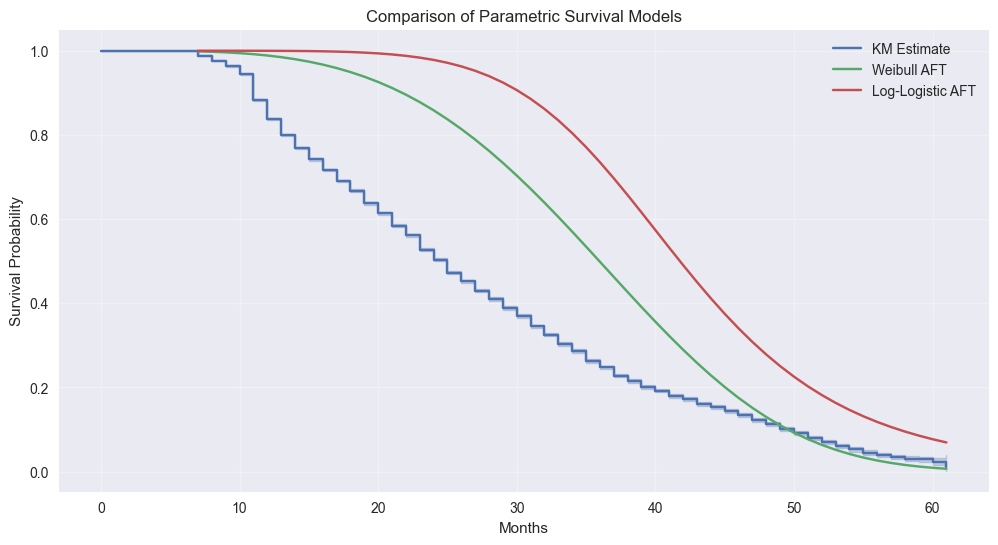

In [79]:
# First, copy your dataframe selecting only the columns in selected_vars
model_df = df[selected_vars].copy()

categorical_vars = model_df.select_dtypes(include=['object', 'category']).columns.tolist()

# One-hot encode categorical variables (drop_first=True to avoid multicollinearity)
model_df_encoded = pd.get_dummies(model_df, columns=categorical_vars, drop_first=True)

model_df = model_df_encoded


# # Check for missing values in the modeling dataset
# print("Missing values in the modeling dataset:")
# print(model_df.isnull().sum())

# Drop rows with missing values
model_df = model_df.dropna()
print(f"Shape after dropping missing values: {model_df.shape}")

# 5.1 Fit Weibull AFT model
print("\nFitting Weibull AFT model...")
waft = WeibullAFTFitter()
waft.fit(model_df, duration_col='months', event_col='churn')

# Display model summary
print("Weibull AFT Model Summary:")
waft_summary = waft.summary
display(waft_summary)
waft_summary.to_csv('weibull_model_summary.csv')

# 5.2 Fit Log-Logistic AFT model
print("\nFitting Log-Logistic AFT model...")
llaft = LogLogisticAFTFitter()
llaft.fit(model_df, duration_col='months', event_col='churn')

# Display model summary
print("Log-Logistic AFT Model Summary:")
llaft_summary = llaft.summary
display(llaft_summary)
llaft_summary.to_csv('loglogistic_model_summary.csv')

# 5.3 Fit Exponential model
print("\nFitting Exponential model...")
exp_fit = ExponentialFitter()
exp_fit.fit(model_df['months'], model_df['churn'])

# Display model fit
print("Exponential Model:")
print(f"Lambda (rate parameter): {exp_fit.lambda_}")

# 5.4 Compare models using AIC
print("\nModel Comparison using AIC:")
print(f"Weibull AFT AIC: {waft.AIC_}")
print(f"Log-Logistic AFT AIC: {llaft.AIC_}")

# Save model comparison to text file
with open('model_comparison.txt', 'w') as f:
    f.write("Model Comparison using AIC:\n")
    f.write(f"Weibull AFT AIC: {waft.AIC_}\n")
    f.write(f"Log-Logistic AFT AIC: {llaft.AIC_}\n")
    f.write(f"Exponential lambda: {exp_fit.lambda_}\n")

# Plot the predicted survival curves of the different models
plt.figure(figsize=(12, 6))

# Original KM curve
kmf = KaplanMeierFitter()
kmf.fit(model_df['months'], model_df['churn'], label='KM Estimate')
kmf.plot_survival_function()

# Weibull predicted curve
waft_pred = waft.predict_survival_function(model_df.iloc[:1])
plt.plot(waft_pred.index, waft_pred.iloc[:, 0], label='Weibull AFT')

# Log-Logistic predicted curve
llaft_pred = llaft.predict_survival_function(model_df.iloc[:1])
plt.plot(llaft_pred.index, llaft_pred.iloc[:, 0], label='Log-Logistic AFT')

plt.title('Comparison of Parametric Survival Models')
plt.xlabel('Months')
plt.ylabel('Survival Probability')
plt.grid(alpha=0.3)
plt.legend()
plt.savefig('figures/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Model Selection and Interpretation

Sorted Model Coefficients by Influence Magnitude:


coef  exp(coef)              p
param   covariate                                                             
lambda_ Intercept                           2.956688  19.234157   0.000000e+00
rho_    Intercept                           1.319746   3.742472   0.000000e+00
lambda_ area_SOUTHWEST AREA                 0.226125   1.253732  1.507677e-213
        area_LOS ANGELES AREA               0.171555   1.187150  2.641113e-126
        area_MIDWEST AREA                   0.113638   1.120346   9.198071e-56
        area_CENTRAL/SOUTH TEXAS AREA       0.105112   1.110835   4.917959e-39
        area_DALLAS AREA                    0.078700   1.081880   1.867343e-26
        new_cell_U                         -0.074310   0.928384   9.940595e-88
        area_GREAT LAKES AREA               0.064593   1.066725   7.453259e-17
        area_TENNESSEE AREA                 0.058592   1.060343   2.210668e-10
        area_HOUSTON AREA                   0.055240   1.056794   4.473986e-12
        area_NEW YORK CITY AREA             0.049457   1.050701   7.723900e-15
        area_OHIO AREA                      0.041004   1.041856   1.669729e-07
        area_DC/MARYLAND/VIRGINIA AREA      0.039970   1.040779   2.349325e-08
        dualband_Y                         -0.037963   0.962749   7.586024e-35
        area_NORTHWEST/ROCKY MOUNTAIN AREA  0.035889   1.036540   2.090500e-06
        area_NEW ENGLAND AREA               0.026659   1.027018   2.455468e-04
        area_CALIFORNIA NORTH AREA          0.026061   1.026404   2.559006e-04
        area_NORTH FLORIDA AREA             0.024866   1.025177   1.285308e-03
        area_CHICAGO AREA                   0.024386   1.024686   1.034795e-03
        area_SOUTH FLORIDA AREA             0.022616   1.022874   6.546732e-03
        area_PHILADELPHIA AREA              0.021897   1.022139   1.894287e-02
        asl_flag_Y                          0.019750   1.019947   4.848876e-06
        dualband_T                         -0.015776   0.984348   3.113921e-02
        new_cell_Y                         -0.008820   0.991219   4.314312e-02
        avgrev                             -0.006459   0.993562   0.000000e+00
        adjrev                              0.001559   1.001560   0.000000e+00
        totrev                             -0.000925   0.999075   0.000000e+00
        totcalls                            0.000721   1.000721   0.000000e+00
        adjqty                             -0.000699   0.999301  1.180876e-295
        rev_Mean                           -0.000299   0.999701   1.537732e-09
        change_rev                         -0.000281   0.999719   1.222821e-29
        avgmou                             -0.000280   0.999720   2.081016e-53
        eqpdays                             0.000247   1.000247   0.000000e+00
        avg6mou                             0.000164   1.000164   1.741568e-42
        avg3qty                            -0.000125   0.999875   2.979170e-07
        mouowylisv_Mean                    -0.000083   0.999917   1.654291e-02
        mou_Mean                            0.000079   1.000079   1.368681e-12
        change_mou                          0.000066   1.000066   8.547911e-25
        avgqty                             -0.000049   0.999951   2.136995e-01
        mou_peav_Mean                      -0.000036   0.999964   2.041456e-02
        mou_cvce_Mean                       0.000020   1.000020   2.586142e-01
        totmou                             -0.000014   0.999986   1.886488e-45
        mou_opkv_Mean                       0.000014   1.000014   4.007532e-01

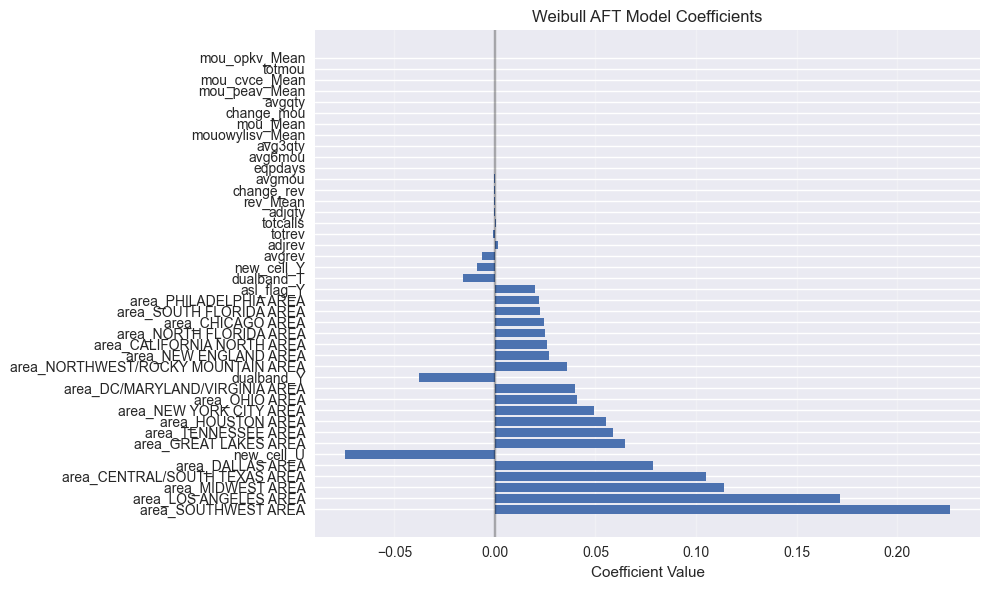

Model coefficients plot saved to 'figures/model_coefficients.png'


In [78]:
# Interpret the coefficients of the Weibull model
waft_summary = waft.summary

# Sort by absolute value of coef to identify most influential factors
waft_summary['abs_coef'] = waft_summary['coef'].abs()
waft_summary = waft_summary.sort_values('abs_coef', ascending=False)

# Display sorted coefficients
print("Sorted Model Coefficients by Influence Magnitude:")
display(waft_summary[['coef', 'exp(coef)', 'p']])

# Save sorted coefficients to CSV
waft_summary[['coef', 'exp(coef)', 'p', 'abs_coef']].to_csv('sorted_coefficients.csv')

# Visualize coefficient effects
plt.figure(figsize=(10, 6))
coefs = waft_summary['coef']
exp_coefs = waft_summary['exp(coef)']
variables = coefs.index.get_level_values(1)

# Removing the intercept for better visualization
mask = variables != 'Intercept'
coefs = coefs[mask]
exp_coefs = exp_coefs[mask]
variables = variables[mask]

plt.barh(variables, coefs)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.title('Weibull AFT Model Coefficients')
plt.xlabel('Coefficient Value')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('figures/model_coefficients.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("Model coefficients plot saved to 'figures/model_coefficients.png'")

# COXPH


c:\Users\felix\AppData\Local\Programs\Python\Python312\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
totmou,-0.000007,0.999993,0.000003,-0.000013,-0.000001,0.999987,0.999999,0.0,-2.296905,2.162417e-02,5.531212
totrev,0.000904,1.000905,0.000095,0.000719,0.001090,1.000719,1.001090,0.0,9.547363,1.330399e-21,69.348631
avgrev,0.007855,1.007885,0.000438,0.006996,0.008713,1.007021,1.008751,0.0,17.939302,5.818093e-72,236.638277
avgmou,0.000948,1.000949,0.000075,0.000801,0.001095,1.000802,1.001096,0.0,12.643273,1.218723e-36,119.304041
rev_Mean,0.001086,1.001086,0.000187,0.000719,0.001453,1.000719,1.001454,0.0,5.795390,6.816271e-09,27.128370
mou_Mean,-0.000144,0.999856,0.000046,-0.000234,-0.000055,0.999766,0.999945,0.0,-3.161289,1.570725e-03,9.314354
change_mou,-0.000126,0.999874,0.000027,-0.000180,-0.000073,0.999820,0.999927,0.0,-4.667313,3.051639e-06,18.321984
change_rev,0.000357,1.000357,0.000108,0.000146,0.000569,1.000146,1.000569,0.0,3.312948,9.231798e-04,10.081101
mou_cvce_Mean,-0.000015,0.999985,0.000063,-0.000139,0.000108,0.999862,1.000108,0.0,-0.238132,8.117784e-01,0.300842


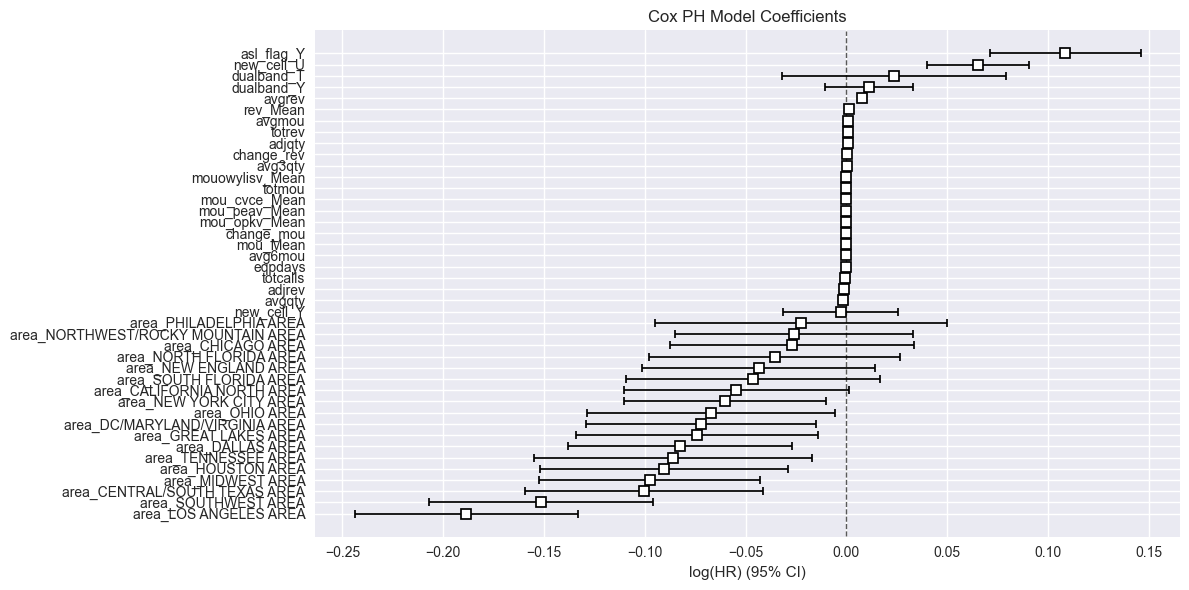

In [77]:
from lifelines import CoxPHFitter
import pandas as pd

# 3. Fit Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit model on duration and event indicator columns: 'months' and 'churn'
cph.fit(model_df, duration_col='months', event_col='churn')

# 4. Print summary
display(cph.summary)

# cph.summary.to_csv('coxph_model_summary.csv')

# 5. Plot the coefficients 
cph.plot()
plt.title('Cox PH Model Coefficients')
plt.tight_layout()
plt.show()